In [2]:
#===== 1. Data Import =====
library(readxl)
library(ggplot2)
library(numDeriv)

options(repr.plot.width = 6, repr.plot.height = 4)  # np. 6 x 4 cale


Dane <- read_excel("Dane 8.1.xlsx")

In [3]:
#===== 2. Data Preparation =====
T <- Dane$T
sum(T == 0) # 2
T[T == 0] <- 0.0025  # there were a few zeros
sum(T == 0)

D <- Dane$D
G <- Dane$G

[1] 2

[1] 0

In [4]:
#===== 3. Function for Estimating Weibull Parameters =====
lik_dane <- function(x) {
  alpha1 <- x[1]  # shape for G = 1
  lambda1 <- x[2] # scale for G = 1
  alpha0 <- x[3]  # shape for G = 0
  lambda0 <- x[4] # scale for G = 0
  
  grupa1 <- (G == 1) * (D * (log(alpha1 / lambda1) + (alpha1 - 1) * log(T / lambda1)) - (T / lambda1)^alpha1)
  grupa0 <- (G == 0) * (D * (log(alpha0 / lambda0) + (alpha0 - 1) * log(T / lambda0)) - (T / lambda0)^alpha0)
  
  return(-sum(grupa1 + grupa0))  
}

In [5]:
#===== 4. Parameter Estimation via MLE =====
mle_dane <- optim(par = c(1, 1, 1, 1), fn = lik_dane, method = "L-BFGS-B", lower = rep(1e-6, 4))

# method = "L-BFGS-B" and lower = rep(1e-6, 4) 
# to prevent negative parameter values


In [6]:
#===== 5. Extraction of Estimated Parameters =====
alpha1 <- mle_dane$par[1]  
lambda1 <- mle_dane$par[2] 
alpha0 <- mle_dane$par[3]  
lambda0 <- mle_dane$par[4] 

In [7]:
#===== 6. For the Plot =====
x <- seq(0, 30, length.out = 300)

df_plot <- data.frame(
  t = rep(x, 2),
  S = c(pweibull(x, shape = alpha1, scale = lambda1, lower.tail = FALSE),
        pweibull(x, shape = alpha0, scale = lambda0, lower.tail = FALSE)),
  grupa = factor(rep(c("G = 1", "G = 0"), each = length(x)))
)

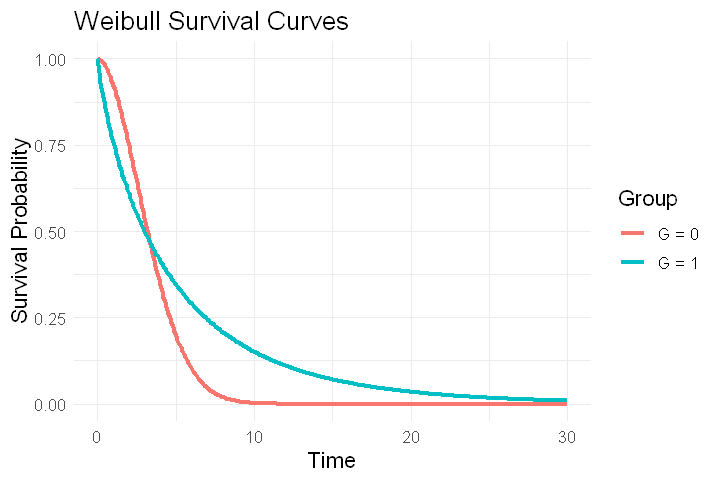

In [8]:
#===== 7. Plot with ggplot2 =====
ggplot(df_plot, aes(x = t, y = S, color = grupa)) +
  geom_line(size = 1.2) +
  labs(title = "Weibull Survival Curves",
       x = "Time",
       y = "Survival Probability",
       color = "Group") +
  theme_minimal() +
  theme(text = element_text(size = 13))

In [9]:
#===== 8. Calculating Median Survival for Both Groups =====
mediana_G1 <- lambda1 * (log(2))^(1 / alpha1)
mediana_G0 <- lambda0 * (log(2))^(1 / alpha0)

cat("Median for G = 1:", round(mediana_G1, 3),
    "\nMedian for G = 0:", round(mediana_G0, 3))

Median for G = 1: 3.002 
Median for G = 0: 3.187

In [10]:
#===== 9. Variance-Covariance Matrix (Asymptotic) =====
# The function lik() is the negative log-likelihood
# So the Hessian matrix = - observed Fisher information matrix
# library(numDeriv)
hessian_macierz <- hessian(func = lik_dane, x = mle_dane$par)
vcov_matrix <- solve(hessian_macierz)
# This gives the asymptotic variance-covariance matrix of the estimators

In [11]:
#===== 10. Delta Method – CI for G = 1 =====
# The relevant part of the covariance matrix
V1 <- vcov_matrix[1:2, 1:2]

# Derivatives for the gradient
# median = g(alpha, lambda) = lambda * (log(2))^(1/alpha)
d_alpha1 <- -lambda1 * (log(2))^(1 / alpha1) * log(log(2)) / (alpha1^2)
d_lambda1 <- (log(2))^(1 / alpha1)

grad1 <- c(d_alpha1, d_lambda1)

# Variance = gradient^T * V * gradient
var_mediana1 <- t(grad1) %*% V1 %*% grad1
se_mediana1 <- sqrt(var_mediana1)

# Confidence interval
PU1 <- c(mediana_G1 - 1.96 * se_mediana1, mediana_G1 + 1.96 * se_mediana1)

In [12]:
#===== 11. Delta Method – CI for G = 0 =====
# Same as before, but for the second set of parameters
V0 <- vcov_matrix[3:4, 3:4]
d_alpha0 <- -lambda0 * (log(2))^(1 / alpha0) * log(log(2)) / (alpha0^2)
d_lambda0 <- (log(2))^(1 / alpha0)
grad0 <- c(d_alpha0, d_lambda0)
var_mediana0 <- t(grad0) %*% V0 %*% grad0
se_mediana0 <- sqrt(var_mediana0)
PU0 <- c(mediana_G0 - 1.96 * se_mediana0, mediana_G0 + 1.96 * se_mediana0)

In [13]:
#===== 12. Obtained 95% Confidence Intervals =====
cat("Median for G = 1:", round(mediana_G1, 3),
    "\n95% CI for median G = 1:", round(PU1[1], 3), "-", round(PU1[2], 3), "\n",
    "\nMedian for G = 0:", round(mediana_G0, 3),
    "\n95% CI for median G = 0:", round(PU0[1], 3), "-", round(PU0[2], 3))

Median for G = 1: 3.002 
95% CI for median G = 1: 2.488 - 3.515 
 
Median for G = 0: 3.187 
95% CI for median G = 0: 2.973 - 3.402

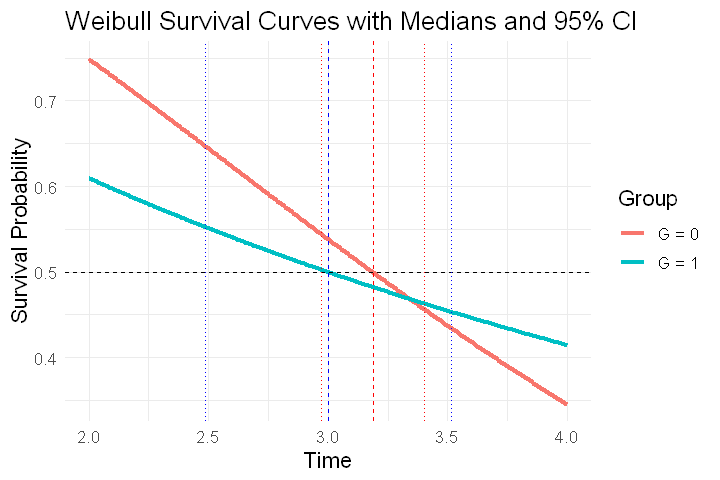

In [14]:
#===== 13. Plot with Marked Medians and Confidence Intervals =====
x <- seq(2, 4, length.out = 300) # for other data – adjust the range accordingly !!!

df_plot <- data.frame(
  t = rep(x, 2),
  S = c(pweibull(x, shape = alpha1, scale = lambda1, lower.tail = FALSE),
        pweibull(x, shape = alpha0, scale = lambda0, lower.tail = FALSE)),
  grupa = factor(rep(c("G = 1", "G = 0"), each = length(x)))
)

ggplot(df_plot, aes(x = t, y = S, color = grupa)) +
  geom_line(size = 1.2) +
  # Horizontal line at S = 0.5
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "black") +
  # Vertical lines – medians
  geom_vline(xintercept = mediana_G1, linetype = "dashed", color = "blue") +
  geom_vline(xintercept = mediana_G0, linetype = "dashed", color = "red") +
  # Vertical lines – 95% CI for medians
  geom_vline(xintercept = PU1[1], linetype = "dotted", color = "blue") +
  geom_vline(xintercept = PU1[2], linetype = "dotted", color = "blue") +
  geom_vline(xintercept = PU0[1], linetype = "dotted", color = "red") +
  geom_vline(xintercept = PU0[2], linetype = "dotted", color = "red") +
  labs(title = "Weibull Survival Curves with Medians and 95% CI",
       x = "Time",
       y = "Survival Probability",
       color = "Group") +
  theme_minimal() +
  theme(text = element_text(size = 13))


In [15]:
#===== 14. Bootstrap for Median in Both Groups =====
# An alternative way to calculate confidence intervals

B <- 1000  # number of repetitions

# number of generated samples per group
n1 <- sum(G == 1)
n0 <- sum(G == 0)

# arrays to store results
boot_median_G1 <- numeric(B)
boot_median_G0 <- numeric(B)

# Bootstrap for G = 1
for (b in 1:B) {
  T_sim <- rweibull(n1, shape = alpha1, scale = lambda1)
  # MLE for simulated data
  mle <- suppressWarnings(
    optim(par = c(1, 1), 
    fn = function(x) {
      a <- x[1] 
      l <- x[2]
      -sum(log(a / l) + (a - 1) * log(T_sim / l) - (T_sim / l)^a)
    }, 
    method = "L-BFGS-B", lower = rep(1e-6, 2))
  )
  a_hat <- mle$par[1]
  l_hat <- mle$par[2]
  boot_median_G1[b] <- l_hat * (log(2))^(1 / a_hat)
}

# Bootstrap for G = 0
for (b in 1:B) {
  T_sim <- rweibull(n0, shape = alpha0, scale = lambda0)
  mle <- suppressWarnings(
    optim(par = c(1, 1), 
    fn = function(x) {
      a <- x[1]
      l <- x[2]
      -sum(log(a / l) + (a - 1) * log(T_sim / l) - (T_sim / l)^a)
    }, 
    method = "L-BFGS-B", lower = rep(1e-6, 2))
  )
  a_hat <- mle$par[1]
  l_hat <- mle$par[2]
  boot_median_G0[b] <- l_hat * (log(2))^(1 / a_hat)
}

# Confidence intervals (percentile method)
PU_boot_G1 <- quantile(boot_median_G1, probs = c(0.025, 0.975))
PU_boot_G0 <- quantile(boot_median_G0, probs = c(0.025, 0.975))

# Results
cat("Median for G = 1:", round(mediana_G1, 3),
    "\n95% CI for median G = 1:", round(PU1[1], 3), "-", round(PU1[2], 3),
    "\nBootstrap CI for median G = 1:", round(PU_boot_G1, 3), "\n",
    "\nMedian for G = 0:", round(mediana_G0, 3),
    "\n95% CI for median G = 0:", round(PU0[1], 3), "-", round(PU0[2], 3),
    "\nBootstrap CI for median G = 0:", round(PU_boot_G0, 3), "\n")


Median for G = 1: 3.002 
95% CI for median G = 1: 2.488 - 3.515 
Bootstrap CI for median G = 1: 2.582 3.547 
 
Median for G = 0: 3.187 
95% CI for median G = 0: 2.973 - 3.402 
Bootstrap CI for median G = 0: 2.986 3.4 


In [16]:
#===== 15. Likelihood Ratio Test =====

# (H1) – unrestricted median model – already fitted above

mle_H1 <- optim(par = c(1, 1, 1, 1), fn = lik_dane, method = "L-BFGS-B", lower = rep(1e-6, 4))
mle_H1$par
lrtest_H1 <- mle_H1$value

# Fit the model under the null hypothesis (H0) with equal medians
lik_H0 <- function(x) {
  alpha1 <- x[1]
  lambda1 <- x[2]
  alpha0 <- x[3]
  
  lambda0 <- lambda1 * (log(2))^(1/alpha1 - 1/alpha0)
  
  grupa1 <- (G == 1) * (D * (log(alpha1 / lambda1) + (alpha1 - 1) * log(T / lambda1)) - (T / lambda1)^alpha1)
  grupa0 <- (G == 0) * (D * (log(alpha0 / lambda0) + (alpha0 - 1) * log(T / lambda0)) - (T / lambda0)^alpha0)
  
  return(-sum(grupa1 + grupa0))
}

mle_H0 <- optim(par = c(1, 1, 1), fn = lik_H0, method = "L-BFGS-B", lower = rep(1e-6, 3))
mle_H0$par
lrtest_H0 <- mle_H0$value

# LR statistic
LR <- 2 * (lrtest_H0 - lrtest_H1)
p_value_lrtest <- 1 - pchisq(LR, df = 1) # 4-3 parameters

# Result
cat("LR statistic:", round(LR, 3),
    "\np-value of the test:", round(p_value_lrtest, 4))


[1] 0.8309202 4.6658623 1.8774368 3.8744112

[1] 0.8379526 4.8959948 1.8679283

LR statistic: 0.411 
p-value of the test: 0.5216

In [17]:
#===== 16. Bootstrap Test for Median Difference under H0: Common Median =====
B <- 1000
n1 <- sum(G == 1)
n0 <- sum(G == 0)

# Fit Weibull model under H0 (common median)
mle_boot_h0 <- optim(par = c(1, 1, 1), fn = function(x) {
  alpha1 <- x[1]  # shape for G = 1
  lambda1 <- x[2] # scale for G = 1
  alpha0 <- x[3]  # shape for G = 0
  
  # Calculate scale for G = 0 to ensure equal medians
  lambda0 <- lambda1 * (log(2))^(1 / alpha1 - 1 / alpha0)
  
  # Log-likelihood
  grupa1 <- (G == 1) * (D * (log(alpha1 / lambda1) + (alpha1 - 1) * log(T / lambda1)) - (T / lambda1)^alpha1)
  grupa0 <- (G == 0) * (D * (log(alpha0 / lambda0) + (alpha0 - 1) * log(T / lambda0)) - (T / lambda0)^alpha0)
  
  return(-sum(grupa1 + grupa0))
}, method = "L-BFGS-B", lower = rep(1e-6, 3))

alpha_boot_h0_1 <- mle_boot_h0$par[1]
lambda_boot_h0_1 <- mle_boot_h0$par[2]
alpha_boot_h0_0 <- mle_boot_h0$par[3]
lambda_boot_h0_0 <- lambda_boot_h0_1 * (log(2))^(1 / alpha_boot_h0_1 - 1 / alpha_boot_h0_0)

# Simulation under H0
boot_diffs_h0 <- numeric(B)

for (b in 1:B) {
  # Generate samples from Weibull with equal median but different shapes
  T_sim_G1 <- rweibull(n1, shape = alpha_boot_h0_1, scale = lambda_boot_h0_1)
  T_sim_G0 <- rweibull(n0, shape = alpha_boot_h0_0, scale = lambda_boot_h0_0)
  
  # Fit Weibull to each simulated group
  mle1 <- optim(par = c(1, 1), fn = function(par) {
    a <- par[1]; l <- par[2]
    -sum(log(a / l) + (a - 1) * log(T_sim_G1 / l) - (T_sim_G1 / l)^a)
  }, method = "L-BFGS-B", lower = rep(1e-6, 2))
  
  mle0 <- optim(par = c(1, 1), fn = function(par) {
    a <- par[1]; l <- par[2]
    -sum(log(a / l) + (a - 1) * log(T_sim_G0 / l) - (T_sim_G0 / l)^a)
  }, method = "L-BFGS-B", lower = rep(1e-6, 2))
  
  m1 <- mle1$par[2] * (log(2))^(1 / mle1$par[1])
  m0 <- mle0$par[2] * (log(2))^(1 / mle0$par[1])
  
  boot_diffs_h0[b] <- m0 - m1
}

# Observed difference
obs_diff <- mediana_G0 - mediana_G1

# p-value
p_value_boot <- mean(abs(boot_diffs_h0) >= abs(obs_diff))
sum(abs(boot_diffs_h0) >= abs(obs_diff))

abs(obs_diff)
head(abs(boot_diffs_h0))

# Result
cat("Observed median difference:", round(abs(obs_diff), 3),
    "\np-value of the test:", round(p_value_boot, 4), "\n")


[1] 520

[1] 0.1855959

[1] 0.71458479 0.06143376 0.04639730 0.16541347 0.64760703 0.26507344

Observed median difference: 0.186 
p-value of the test: 0.52 
